In [ ]:
#pip install recommenders


In [ ]:
#print(tf.executing_eagerly())  # should be True now

In [19]:
import kagglehub 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
import tensorflow as tf 
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout,Attention,Multiply
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Model
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping
from time import time
#from recommenders.evaluation.python_evaluation import (
    #map, ndcg_at_k, precision_at_k, recall_at_k
#)
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm 
from collections import defaultdict,Counter

#### STEP 1 : LOADING THE DATASET FROM KAGGLE 

In [ ]:
devices = tf.config.get_visible_devices()
print(devices)

In [ ]:
#strategy = tf.distribute.MirroredStrategy()

In [ ]:
#path = kagglehub.dataset_download("samlearner/letterboxd-movie-ratings-data")

#print("Path to dataset files:", path)

In [ ]:
#movie_data_filename = 'movie_data.csv'
#ratings_filename = 'ratings_export.csv'
#users_filename = 'users_export.csv'
#movie_data_path = os.path.join(path,movie_data_filename)
#ratings_path = os.path.join(path,ratings_filename)
#users_path = os.path.join(path,users_filename)

In [ ]:
# movie_data_df = pd.read_csv(movie_data_path,engine='python')
# ratings_df = pd.read_csv(ratings_path,engine='python')
# users_df = pd.read_csv(users_path,engine = 'python')

In [2]:
movie_data_df = pd.read_parquet('movie_data.parquet',engine='pyarrow')
ratings_df = pd.read_parquet('ratings_data.parquet',engine='pyarrow')
users_df = pd.read_parquet('users_dt.parquet',engine='pyarrow')

In [ ]:
print(users_df.head())


# this dataframe won't be used, as we don't want the models predictions to depend on the users data. 

unneccessary columns need to be removed - image url, imdb id, imdb, link (perhaps needed to enhance model with imdb data ? ), tmbd id, link, (download that dataset and enhance with it ? )production countries, 

In [ ]:
print(movie_data_df.info())


# we can check if adding additional information from this dataframe to the model improves its performance (genre of the movie, overview? tokenized, year_released)

In [ ]:
print(ratings_df.head())

In [ ]:
print(ratings_df.info())

In [ ]:
for col in movie_data_df.select_dtypes(include='object'):
    print(f"{col}: {movie_data_df[col].nunique()} unique values")


In [ ]:
#movie_data_df.to_parquet('movie_data.parquet', engine='pyarrow')
#ratings_df.to_parquet('ratings_data.parquet', engine = 'pyarrow')
#users_df.to_parquet('users_dt.parquet',engine = 'pyarrow')
# Load from Parquet file



#### STEP 2: EXPLORATORY DATA ANALYSIS 

#### STEP 3: DEFINING THE TASK, EVALUATION METRICS, CONSTRUCTING MODEL 

In [ ]:
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


In [ ]:
model.load_weights('ncf_model.weights.h5')
# model can be saved locally after training so it doesn't have to be redone again 

In [ ]:
#texts = movie_data_df['overview'].fillna('').tolist()
#inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf", max_length=128)
#with strategy.scope():
    #outputs = model(**inputs).last_hidden_state.mean(dim=1)

# Get embeddings (use outputs.last_hidden_state or outputs.pooler_output)
#movie_df['embedding'] = embeddings.numpy().tolist()

In [9]:
#ratings_df.dropna(subset=['user_id', 'movie_id', 'rating_val'], inplace=True)

In [ ]:
ratings_df.head()

# non integer frames must be mapped to a unique numeric value - movie id and user id in this case

In [5]:
user_mapping = {user: idx for idx, user in enumerate(ratings_df['user_id'].unique())}
item_mapping = {item: idx for idx, item in enumerate(ratings_df['movie_id'].unique())}


In [ ]:
sample_items = list(user_mapping.items())[:10]
print(sample_items)

In [ ]:
ratings_df['user_id'] = ratings_df['user_id'].map(user_mapping)
ratings_df['movie_id'] = ratings_df['movie_id'].map(item_mapping)
ratings_df.head()

In [ ]:
ratings_df = ratings_df.drop(['_id'],axis = 1)
ratings_df.head()

In [9]:
train, val = train_test_split(ratings_df, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size = 0.2, random_state = 42)

In [ ]:
n_users = len(user_mapping)
n_items = len(item_mapping)
print(f'No. users : {n_users}, no. items : {n_items}')
#print(user_mapping)

# easiest to construct model using functional API (multiple input network). 3 dense layers of sizes 64,32,16 respectively follow the embedding layers

In [ ]:
embedding_dim = 32  # Latent factor size
mlp_layer_sizes = [64, 32, 16]  # Fully connected layers

# 1d input for user and item 
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding layers
user_embedding = Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(n_items, embedding_dim, name='item_embedding')(item_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

gmf_vec = Multiply()([user_vec,item_vec])
# Concatenate embeddings
concat_vec = Concatenate()([user_vec, item_vec])
# MLP layers
mlp = concat_vec
for size in mlp_layer_sizes:
    mlp = Dense(size, activation='relu')(mlp)
    mlp = Dropout(0.2)(mlp)

pre_output_concatenate = Concatenate()([gmf_vec,mlp])
# Output layer (e.g., single rating prediction)
output = Dense(1, activation='linear', name='output')(pre_output_concatenate)

# Build and compile the model
ncf_model = Model(inputs=[user_input, item_input], outputs=output)
ncf_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ncf_model.summary()


In [ ]:
#tf.config.get_visible_devices()

In [12]:
train_dict = defaultdict(set)

# Assuming your train DataFrame has columns 'user_id' and 'movie_id':
for user, item in zip(train['user_id'], train['movie_id']):
    train_dict[user].add(item)
    

In [22]:
x_train = [train['user_id'].values, train['movie_id'].values]
y_train = train['rating_val'].values
x_val = [val['user_id'].values, val['movie_id'].values]
y_val = val['rating_val'].values
x_test = [test['user_id'].values, test['movie_id'].values]
y_test = test['rating_val'].values
print(y_test.shape)
print(y_val.shape)
print(type(x_train))
print(type(x_test))
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)
# Train the model
history = ncf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks = [early_stop_callback]
)
#uncomment above to train model again, weights can be loaded aswell

27696/27696 ━━━━━━━━━━━━━━━━━━━━ 786s 28ms/step - loss: 3.9399 - mae: 1.4924 - val_loss: 2.1359 - val_mae: 1.1195
Epoch 2/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 868s 31ms/step - loss: 2.0036 - mae: 1.0795 - val_loss: 1.9928 - val_mae: 1.0774
Epoch 3/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 887s 32ms/step - loss: 1.7615 - mae: 1.0044 - val_loss: 1.9651 - val_mae: 1.0677
Epoch 4/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 877s 32ms/step - loss: 1.6202 - mae: 0.9578 - val_loss: 1.9739 - val_mae: 1.0702


In [ ]:
#ncf_model.load_weights('ncf_model.weights.h5')

In [23]:
ncf_model.save_weights('ncf_model.weights.h5')

In [24]:
loss, mae = ncf_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# RMSE
predictions = ncf_model.predict(x_test)
rmse = sqrt(np.mean((predictions.flatten() - y_test) ** 2))
print(f"Test RMSE: {rmse:.4f}")

55391/55391 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - loss: 1.9698 - mae: 1.0692
Test Loss: 1.9645, Test MAE: 1.0678
55391/55391 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step
Test RMSE: 1.4016


In [25]:
user_id = 'jay'  # Replace with a valid user_id
user_idx = user_mapping.get(user_id)
print(user_idx)
# Predict ratings for all items
all_items = np.arange(n_items)
user_tensor = np.array([user_idx] * n_items)
predicted_ratings = ncf_model.predict([user_tensor, all_items])

# Get top 10 recommendations
top_items = np.argsort(predicted_ratings.flatten())[::-1][:10]
recommended_movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(idx)] for idx in top_items]
print(f"Recommended movies for user {user_id}: {recommended_movie_ids}")

7
8940/8940 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Recommended movies for user jay: ['parasite-2019', 'cowboy-bebop', 'my-mister', 'the-human-condition-iii-a-soldiers-prayer', 'come-and-see', 'portrait-of-a-lady-on-fire', 'company-2008', 'twin-peaks-the-return', 'moonlight-2016', 'mishima-a-life-in-four-chapters']


In [26]:
test = test.rename(columns={'rating_val': 'prediction'})

In [ ]:
print(test)

In [32]:
# all_user_ids = list(user_mapping.keys())       # e.g. original user IDs
# all_user_idxs = list(user_mapping.values())    # integer indices
# BATCH_SIZE = 512
# all_items = np.arange(n_items)

# predictions_list = []
# for i in range(0, len(all_user_idxs), BATCH_SIZE):
#     # Take a chunk of users
#     user_idx_batch = all_user_idxs[i : i + BATCH_SIZE]
#     user_id_batch = all_user_ids[i : i + BATCH_SIZE]

#     # Repeat items for each user in the batch
#     # shape: (#users_in_batch * n_items,)
#     tile_users = np.repeat(user_idx_batch, n_items)
#     tile_items = np.tile(all_items, len(user_idx_batch))

#     # Model predict on that entire chunk
#     batch_preds = ncf_model.predict([tile_users, tile_items])  

#     # Now we map predictions back to (user, item) pairs
#     # We'll build a DataFrame
#     df_chunk = pd.DataFrame({
#         "userID": np.repeat(user_id_batch, n_items),
#         "itemID": tile_items,
#         "prediction": batch_preds
#     })
#     predictions_list.append(df_chunk)

# predictions_df = pd.concat(predictions_list, ignore_index=True)
### 1 HOUR 45 MINS FOR ENTIRE DATASET 

In [33]:
# print(predictions_df)

In [27]:
test.rename(
    columns={
        "movie_id": "itemID",
        "user_id": "userID",
        "rating_val": "rating"  
    },
    inplace=True,
)

train.rename(
    columns={
        "movie_id": "itemID",  
        "user_id": "userID"
    },
    inplace=True,
)

In [34]:
# # Evaluate predictions
# #eval_map = map(test, predictions_df, col_prediction='prediction', k=TOP_K)
# eval_ndcg = ndcg_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# eval_precision = precision_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# eval_recall = recall_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# print(
#     #f"MAP:\t{eval_map:.6f}",
#     f"NDCG:\t{eval_ndcg:.6f}",
#     f"Precision@K:\t{eval_precision:.6f}",
#     f"Recall@K:\t{eval_recall:.6f}",
#     sep='\n'
# )

## COMPLEXITY OF PREDICTING FOR ALL USERS AND ITEMS IS (no_users * no_items) -> VERY LARGE. 
Use negative sampling - take 1 item user interacted with, and 50 or 100 items the user did NOT interact (did not rate). 

# with manual testing for different users, the model basically outputs the highest rated shows and movies that the user has not rated. how to improve on that ? -> tokenization of movie descriptions into the model, another pipeline with the genre. 

In [ ]:
print(train)

In [ ]:
print(test)

In [29]:
all_items_set = set(train['itemID'].unique()) | set(test['itemID'].unique())

In [30]:
# Parameters
k = 10
hits = []
ndcgs = []
precisions = []
recalls = []
all_true_labels = []
all_pred_scores = []
recommended_items = []

unique_user_ids = test['userID'].unique()

# Evaluation Loop
for user_id in tqdm(unique_user_ids[:100], desc="Processing users"):
    # Fetch the test items for the user
    test_items = test.loc[test['userID'] == user_id, 'itemID'].values
    pos_items = set(test_items)  
    limited_pos_items = list(pos_items)[:3] # take only 3, on processor only takes too slow for all 
    # Build negative set (exclude train_dict[user_id] + the positive items)
    user_train_items = train_dict[user_id] | set(limited_pos_items)
    possible_negatives = list(all_items_set - user_train_items)

    # Iterate over each positive item
    for pos_item in limited_pos_items:
        # Sample 99 negatives for the current positive item
        neg_sample = random.sample(list(all_items_set - train_dict[user_id] - {pos_item}), 99)
        
        # Combine into a batch
        item_batch = [pos_item] + neg_sample
        user_batch = [user_id] * len(item_batch)
        
        # Get predictions
        scores = ncf_model.predict([np.array(user_batch), np.array(item_batch)])
        scores = np.squeeze(scores)
        
        # Binary labels: 1 for positive item, 0 for negatives
        labels = np.array([1] + [0]*99)
        all_true_labels.extend(labels)
        all_pred_scores.extend(scores)
        
        # Sort items by score in descending order
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = labels[sorted_indices]
        sorted_items = np.array(item_batch)[sorted_indices]
        
        # Collect recommended items for distribution analysis
        top_k_items = sorted_items[:k]
        recommended_items.extend(top_k_items.tolist())
        
        # Calculate Hit@K, if positive item in these, its a hit
        if 1 in sorted_labels[:k]:
            hits.append(1)
        else:
            hits.append(0)
        
        # Calculate NDCG@K
        rank = np.where(sorted_labels[:k] == 1)[0]
        if len(rank) > 0:
            ndcgs.append(1 / np.log2(rank[0] + 2))  
        else:
            ndcgs.append(0)
        
        # Calculate Precision@K
        precision = np.sum(sorted_labels[:k]) / k
        precisions.append(precision)
        
        # Calculate Recall@K
        recall = np.sum(sorted_labels[:k]) / len(limited_pos_items)
        recalls.append(recall)

# Calculate Final Metrics
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)



Processing users:   0%|          | 0/100 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Processing users:   1%|          | 1/100 [00:00<00:49,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:   2%|▏         | 2/100 [00:01<00:53,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Processing users:   3%|▎         | 3/100 [00:01<00:40,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:   4%|▍         | 4/100 [00:01<00:37,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:   5%|▌         | 5/100 [00:02<00:38,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing users:   6%|▌         | 6/100 [00:02<00:41,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Processing users:   7%|▋         | 7/100 [00:03<00:43,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing users:   8%|▊         | 8/100 [00:03<00:48,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing users:   9%|▉         | 9/100 [00:04<00:43,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  10%|█         | 10/100 [00:04<00:40,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing users:  11%|█         | 11/100 [00:04<00:36,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:  12%|█▏        | 12/100 [00:05<00:40,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  13%|█▎        | 13/100 [00:05<00:41,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Processing users:  14%|█▍        | 14/100 [00:06<00:41,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  15%|█▌        | 15/100 [00:06<00:34,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  16%|█▌        | 16/100 [00:06<00:29,  2.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  17%|█▋        | 17/100 [00:07<00:28,  2.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  18%|█▊        | 18/100 [00:07<00:32,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:  19%|█▉        | 19/100 [00:08<00:34,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:  20%|██        | 20/100 [00:08<00:37,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  21%|██        | 21/100 [00:09<00:37,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  22%|██▏       | 22/100 [00:09<00:36,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  23%|██▎       | 23/100 [00:10<00:38,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  24%|██▍       | 24/100 [00:10<00:35,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  25%|██▌       | 25/100 [00:11<00:35,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Processing users:  26%|██▌       | 26/100 [00:11<00:32,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Processing users:  27%|██▋       | 27/100 [00:12<00:32,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing users:  28%|██▊       | 28/100 [00:12<00:31,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  29%|██▉       | 29/100 [00:13<00:33,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Processing users:  30%|███       | 30/100 [00:13<00:33,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  31%|███       | 31/100 [00:13<00:31,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  32%|███▏      | 32/100 [00:14<00:32,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  33%|███▎      | 33/100 [00:14<00:33,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  34%|███▍      | 34/100 [00:15<00:29,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  35%|███▌      | 35/100 [00:15<00:30,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:  36%|███▌      | 36/100 [00:16<00:31,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  37%|███▋      | 37/100 [00:16<00:27,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  38%|███▊      | 38/100 [00:16<00:24,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  39%|███▉      | 39/100 [00:17<00:24,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  40%|████      | 40/100 [00:17<00:22,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  41%|████      | 41/100 [00:18<00:21,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  42%|████▏     | 42/100 [00:18<00:22,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  43%|████▎     | 43/100 [00:18<00:22,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  44%|████▍     | 44/100 [00:19<00:23,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  45%|████▌     | 45/100 [00:19<00:24,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  46%|████▌     | 46/100 [00:20<00:25,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  47%|████▋     | 47/100 [00:20<00:24,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  48%|████▊     | 48/100 [00:21<00:24,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  49%|████▉     | 49/100 [00:21<00:24,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  50%|█████     | 50/100 [00:22<00:23,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  51%|█████     | 51/100 [00:22<00:23,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  52%|█████▏    | 52/100 [00:23<00:23,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  53%|█████▎    | 53/100 [00:23<00:23,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Processing users:  54%|█████▍    | 54/100 [00:24<00:22,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Processing users:  55%|█████▌    | 55/100 [00:24<00:23,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  56%|█████▌    | 56/100 [00:25<00:21,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  57%|█████▋    | 57/100 [00:25<00:19,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  58%|█████▊    | 58/100 [00:26<00:20,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  59%|█████▉    | 59/100 [00:26<00:19,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  60%|██████    | 60/100 [00:27<00:19,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  61%|██████    | 61/100 [00:27<00:18,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Processing users:  62%|██████▏   | 62/100 [00:28<00:18,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  63%|██████▎   | 63/100 [00:28<00:17,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  64%|██████▍   | 64/100 [00:28<00:14,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  65%|██████▌   | 65/100 [00:29<00:12,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  66%|██████▌   | 66/100 [00:29<00:11,  2.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  67%|██████▋   | 67/100 [00:29<00:10,  3.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing users:  68%|██████▊   | 68/100 [00:30<00:10,  3.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Processing users:  69%|██████▉   | 69/100 [00:30<00:10,  3.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  70%|███████   | 70/100 [00:30<00:11,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  71%|███████   | 71/100 [00:31<00:09,  3.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  72%|███████▏  | 72/100 [00:31<00:10,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  73%|███████▎  | 73/100 [00:31<00:10,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  74%|███████▍  | 74/100 [00:32<00:11,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  75%|███████▌  | 75/100 [00:33<00:11,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  76%|███████▌  | 76/100 [00:33<00:11,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  77%|███████▋  | 77/100 [00:34<00:11,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  78%|███████▊  | 78/100 [00:34<00:09,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  79%|███████▉  | 79/100 [00:34<00:07,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Processing users:  80%|████████  | 80/100 [00:34<00:07,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  81%|████████  | 81/100 [00:35<00:07,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Processing users:  82%|████████▏ | 82/100 [00:35<00:06,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  83%|████████▎ | 83/100 [00:36<00:06,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing users:  84%|████████▍ | 84/100 [00:36<00:06,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  85%|████████▌ | 85/100 [00:37<00:06,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Processing users:  86%|████████▌ | 86/100 [00:37<00:06,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  87%|████████▋ | 87/100 [00:37<00:05,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  88%|████████▊ | 88/100 [00:38<00:04,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  89%|████████▉ | 89/100 [00:38<00:04,  2.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  90%|█████████ | 90/100 [00:39<00:04,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  91%|█████████ | 91/100 [00:39<00:04,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Processing users:  92%|█████████▏| 92/100 [00:40<00:04,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  93%|█████████▎| 93/100 [00:40<00:03,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  94%|█████████▍| 94/100 [00:41<00:03,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Processing users:  95%|█████████▌| 95/100 [00:41<00:02,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing users:  96%|█████████▌| 96/100 [00:42<00:01,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users:  97%|█████████▋| 97/100 [00:42<00:01,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing users:  98%|█████████▊| 98/100 [00:43<00:00,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Processing users:  99%|█████████▉| 99/100 [00:43<00:00,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Processing users: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


In [31]:
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)

print(f"Hit Rate@{k}: {hit_rate:.4f}")
print(f"NDCG@{k}: {ndcg:.4f}")
print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"Recall@{k}: {recall_at_k:.4f}")
print(f"ROC AUC: {auc:.4f}")

Hit Rate@10: 0.4800
NDCG@10: 0.2956
Precision@10: 0.0480
Recall@10: 0.1600
ROC AUC: 0.7042


## Interpretation :
- 45% of users get something relevant to them recommended 
- ndcg : 29% to an ideal ranking system (higher relevance items raise it )
- precision : 1 of 22 items is relevant to user (too low!)
- recall : 15% of a users relevant items are 

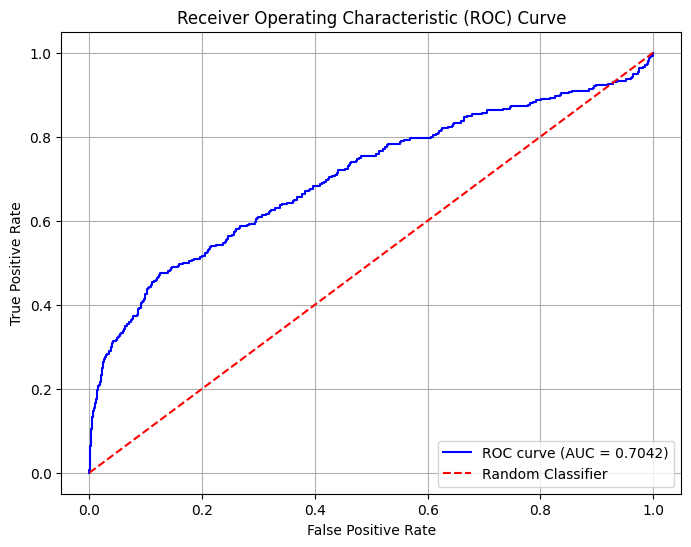

In [39]:
fpr, tpr, thresholds = roc_curve(all_true_labels, all_pred_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('first_curve.png')
plt.show()

## Interesting to check the distribution of the recomended movies for each user. 

In [33]:
item_counts = Counter(recommended_items)
item_counts_df = pd.DataFrame.from_dict(item_counts, orient='index', columns=['count'])
item_counts_df.reset_index(inplace=True)
item_counts_df.rename(columns={'index': 'itemID'}, inplace=True)
item_counts_df.sort_values(by='count', ascending=False, inplace=True)

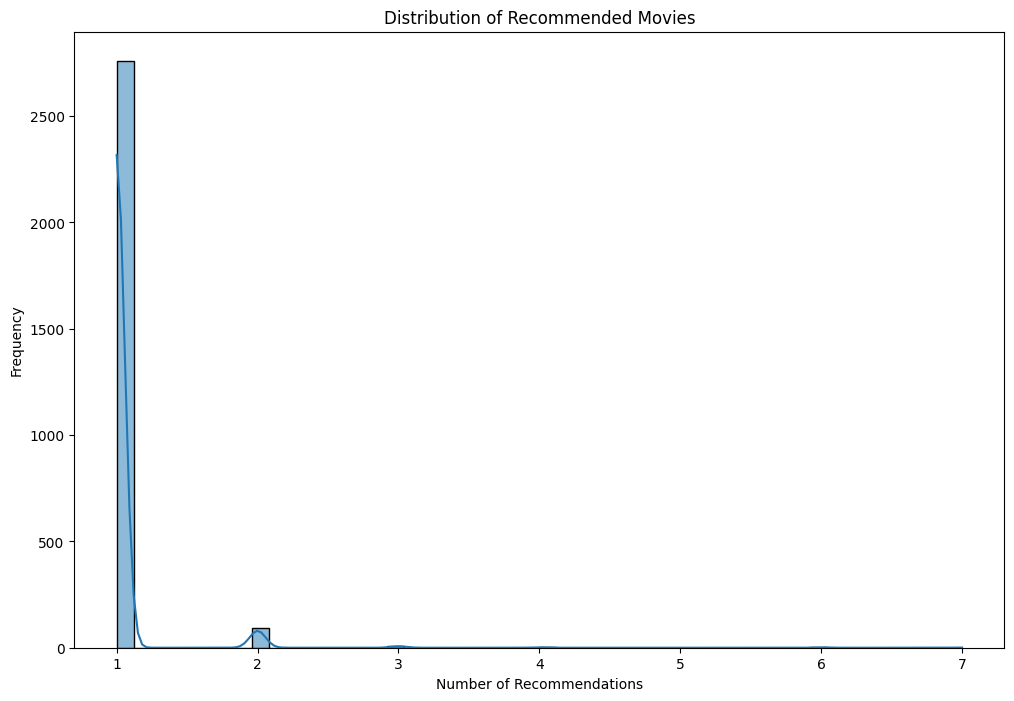

In [34]:
plt.figure(figsize=(12, 8))
sns.histplot(item_counts_df['count'], bins=50, kde=True)
plt.xlabel('Number of Recommendations')
plt.ylabel('Frequency')
plt.title('Distribution of Recommended Movies')
plt.show()

In [35]:
## heavy bias to the highest rated movies (can also be seen by the manual checks for each user)

In [ ]:
# Hit@10: 0.4800
#NDCG@10: 0.3067

In [ ]:
# The relevant items is in 48 percent of reccomended lists to the user, ndcg of 30 percent means we are 30 percent to an ideal ranking 

## This is a good baseline, however it can be improved, in multiple ways

## 1. Train GMF and MLP models separately, then combine into new model, fine-tune that one to see if improvements (paper suggests this technique gives better results)

In [36]:
user_gmf_embedding = Embedding(n_users, embedding_dim, name='user_gmf_embedding')(user_input)
item_gmf_embedding = Embedding(n_items, embedding_dim, name='item_gmf_embedding')(item_input)

# Flatten embeddings
user_gmf_vec = Flatten()(user_gmf_embedding)
item_gmf_vec = Flatten()(item_gmf_embedding)

# Element-wise product of user and item embeddings
gmf_vec = Multiply()([user_gmf_vec, item_gmf_vec])

# Output layer
gmf_output = Dense(1, activation='linear', name='gmf_output')(gmf_vec)

# Build and compile GMF model
gmf_model = Model(inputs=[user_input, item_input], outputs=gmf_output)
gmf_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

gmf_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_gmf_embedding  │ (None, 1, 32)     │    239,264 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_gmf_embedding  │ (None, 1, 32)     │  9,154,272 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 32)        │          0 │ user_gmf_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 32)        │          0 │ item_gmf_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 32)        │          0 │ flatten_8[0][0],  │
│ (Multiply)          │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmf_output (Dense)  │ (None, 1)         │         33 │ multiply_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,393,569 (35.83 MB)

 Trainable params: 9,393,569 (35.83 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# MLP model - neural network 
user_mlp_embedding = Embedding(n_users, embedding_dim, name='user_mlp_embedding')(user_input)
item_mlp_embedding = Embedding(n_items, embedding_dim, name='item_mlp_embedding')(item_input)

# Flatten embeddings
user_mlp_vec = Flatten()(user_mlp_embedding)
item_mlp_vec = Flatten()(item_mlp_embedding)

# Concatenate embeddings
mlp_vec = Concatenate()([user_mlp_vec, item_mlp_vec])

# Fully connected layers
mlp = mlp_vec
for size in mlp_layer_sizes:
    mlp = Dense(size, activation='relu')(mlp)
    mlp = Dropout(0.2)(mlp)

# Output layer
mlp_output = Dense(1, activation='linear', name='mlp_output')(mlp)

# Build and compile MLP model
mlp_model = Model(inputs=[user_input, item_input], outputs=mlp_output)
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [38]:
# Train GMF model
gmf_history = gmf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1
)

# Train MLP model
mlp_history = mlp_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 791s 29ms/step - loss: 10.9400 - mae: 2.3753 - val_loss: 2.1757 - val_mae: 1.1298
Epoch 2/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 895s 32ms/step - loss: 2.0397 - mae: 1.0904 - val_loss: 2.0429 - val_mae: 1.0905
Epoch 3/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 904s 33ms/step - loss: 1.8091 - mae: 1.0189 - val_loss: 2.0071 - val_mae: 1.0799
Epoch 4/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 923s 33ms/step - loss: 1.6597 - mae: 0.9700 - val_loss: 2.0084 - val_mae: 1.0798
Epoch 5/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 909s 33ms/step - loss: 1.5558 - mae: 0.9334 - val_loss: 2.0220 - val_mae: 1.0837
Epoch 1/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 936s 34ms/step - loss: 4.1119 - mae: 1.5279 - val_loss: 2.2539 - val_mae: 1.1564
Epoch 2/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 933s 34ms/step - loss: 2.2182 - mae: 1.1440 - val_loss: 2.1369 - val_mae: 1.1229
Epoch 3/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 917s 33ms/step - loss: 2.1072 - mae: 1.1112 - val_loss: 2.1026 - val_mae: 1.1094
Epoch 4

In [ ]:
combined = Concatenate()([gmf_vec, mlp])
final_output = Dense(1, activation='linear', name='final_output')(combined)

# Build the final model
ncf_combined_model = Model(inputs=[user_input, item_input], outputs=final_output)
ncf_combined_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ncf_combined_model.summary()

## 2. Improve on the suggested architecture :
- use other information in the dataset: ex. genre, popularity, overview of the movies 
- add layers to the model - batch normalization, dropout, change loss function, 
- evaluate the model with tenfold cross validation 
- ensemble with tokenization of movie overview 
- add precision@k,AUC,recall@k,mean reciprocal rank (MRR)
- graph embeddings ? 
- l1-l2 regularization
- autoencoder of user and item 
